In [1]:
import pandas as pd
import os
import numpy as np
import scipy as sp
import torch

In [2]:
from scipy.stats import uniform, norm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [3]:
A = 1.2
b = -0.3
sigma = 0.2
N = 100

In [4]:
np.random.seed(0)
X = torch.from_numpy(uniform.rvs(size=N))
X.detach()
X = X.float()

In [5]:
e = torch.from_numpy(norm.rvs(loc=0, scale=sigma, size=N)).float()

In [6]:
y = A*X + b + e

In [7]:
y.detach()
y = y.float()

In [8]:
def sigma_to_rho(sigma):
    rho = torch.log(torch.exp(sigma) - 1)
    return rho

In [9]:
def rho_to_sigma(rho):
    sigma = torch.log(1 + torch.exp(rho))
    return sigma

In [10]:
def log_q_pdf(w, theta):
    (mu_A, mu_b, rho_A, rho_b) = theta 
    
    sigma_A = rho_to_sigma(rho_A)
    qA = torch.distributions.normal.Normal(mu_A, sigma_A)
    
    sigma_b = rho_to_sigma(rho_b)
    qb = torch.distributions.normal.Normal(mu_b, sigma_b)
    
    lp = qA.log_prob(w[0]) + qb.log_prob(w[1])
    return lp

In [11]:
def log_p_pdf(w):
    prior_mu_A = torch.tensor(0.0) 
    prior_sigma_A = torch.tensor(1.0)
    pA = torch.distributions.normal.Normal(prior_mu_A, prior_sigma_A)
    
    prior_mu_b = torch.tensor(0.0) 
    prior_sigma_b = torch.tensor(1.0)
    pb = torch.distributions.normal.Normal(prior_mu_b, prior_sigma_b)
    
    lp = pA.log_prob(w[0]) + pb.log_prob(w[1])
    return lp

In [12]:
def likelihood(y,X,w):
    A = w[0]
    b = w[1]
    
    y_pred = A*X + b
    lp = torch.distributions.normal.Normal(y_pred, 0.2).log_prob(y).sum()
    return lp

In [13]:
def f(w, theta):
    v = log_q_pdf(w, theta) - log_p_pdf(w) - likelihood(y,X,w)
    return v

In [14]:
mu_A = torch.tensor(0.0)
sigma_A = torch.tensor(0.1)
rho_A = sigma_to_rho(sigma_A)
mu_b = torch.tensor(0.0)
sigma_b = torch.tensor(0.1)
rho_b = sigma_to_rho(sigma_b)

theta = torch.tensor([mu_A, mu_b, rho_A, rho_b], requires_grad=True)

In [15]:
alpha = torch.tensor(10e-5)

In [16]:
for i in range(0,1000):
    lst_grad_mu = []
    lst_grad_rho = []
    lst_v = []
    for j in range(0,20):
        epsilon = torch.distributions.normal.Normal(torch.tensor(0.0) , torch.tensor(1.0)).sample(torch.Size([2,]))

        with torch.no_grad():
            w = theta[0:2].clone().detach() + torch.log(1 + torch.exp(theta[2:4].clone().detach()))*epsilon
        w.requires_grad = True

        v = f(w, theta)   
        v.backward()
        lst_v.append(v.data)
        v = torch.tensor([])

        with torch.no_grad():
            grad_mu = w.grad + theta.grad[0:2]
            grad_rho = w.grad*epsilon/(1 + torch.exp(-theta[2:4])) + -theta.grad[2:4]


        lst_grad_mu.append(grad_mu)
        lst_grad_rho.append(grad_rho)

        theta.grad.zero_()
        w.grad.zero_()
        v.detach()
    grad_mu = torch.stack(lst_grad_mu).mean(dim=0)
    grad_rho = torch.stack(lst_grad_rho).mean(dim=0)
    
    print(torch.stack(lst_v).mean())
    #print(grad_mu)
    #print(grad_rho)
        
    with torch.no_grad():
        theta[0:2] -= alpha*grad_mu
        theta[2:4] -= alpha*grad_rho
    
    print(theta)



tensor(257.8371)
tensor([ 0.0611,  0.0767, -2.2530, -2.2529], requires_grad=True)
tensor(189.3925)
tensor([ 0.1105,  0.1309, -2.2540, -2.2550], requires_grad=True)
tensor(146.3087)
tensor([ 0.1500,  0.1679, -2.2543, -2.2585], requires_grad=True)
tensor(110.3447)
tensor([ 0.1757,  0.1768, -2.2550, -2.2599], requires_grad=True)
tensor(109.7005)
tensor([ 0.2054,  0.1946, -2.2554, -2.2619], requires_grad=True)
tensor(100.9540)
tensor([ 0.2250,  0.1925, -2.2562, -2.2639], requires_grad=True)
tensor(95.8902)
tensor([ 0.2455,  0.1936, -2.2567, -2.2661], requires_grad=True)
tensor(95.5139)
tensor([ 0.2713,  0.2054, -2.2579, -2.2678], requires_grad=True)
tensor(90.6614)
tensor([ 0.2861,  0.1961, -2.2588, -2.2701], requires_grad=True)
tensor(84.0318)
tensor([ 0.3047,  0.1954, -2.2597, -2.2716], requires_grad=True)
tensor(82.0238)
tensor([ 0.3191,  0.1876, -2.2608, -2.2735], requires_grad=True)
tensor(81.2155)
tensor([ 0.3344,  0.1810, -2.2617, -2.2755], requires_grad=True)
tensor(69.8464)
tensor

tensor(3.9895)
tensor([ 1.0010, -0.1603, -2.3175, -2.4503], requires_grad=True)
tensor(5.2882)
tensor([ 1.0101, -0.1512, -2.3181, -2.4525], requires_grad=True)
tensor(-1.2765)
tensor([ 1.0161, -0.1460, -2.3186, -2.4539], requires_grad=True)
tensor(2.9042)
tensor([ 1.0151, -0.1547, -2.3192, -2.4558], requires_grad=True)
tensor(-1.2818)
tensor([ 1.0202, -0.1521, -2.3198, -2.4571], requires_grad=True)
tensor(-1.6153)
tensor([ 1.0190, -0.1613, -2.3202, -2.4583], requires_grad=True)
tensor(1.5064)
tensor([ 1.0138, -0.1772, -2.3210, -2.4599], requires_grad=True)
tensor(-4.6367)
tensor([ 1.0166, -0.1786, -2.3214, -2.4608], requires_grad=True)
tensor(-2.3137)
tensor([ 1.0225, -0.1734, -2.3224, -2.4614], requires_grad=True)
tensor(-5.9736)
tensor([ 1.0251, -0.1744, -2.3226, -2.4624], requires_grad=True)
tensor(-1.8741)
tensor([ 1.0279, -0.1754, -2.3231, -2.4637], requires_grad=True)
tensor(-0.5251)
tensor([ 1.0297, -0.1788, -2.3236, -2.4652], requires_grad=True)
tensor(-4.6492)
tensor([ 1.0288,

tensor(-7.0591)
tensor([ 1.1499, -0.2319, -2.3695, -2.5843], requires_grad=True)
tensor(-2.8993)
tensor([ 1.1502, -0.2334, -2.3700, -2.5859], requires_grad=True)
tensor(-6.2934)
tensor([ 1.1481, -0.2386, -2.3705, -2.5868], requires_grad=True)
tensor(-6.9026)
tensor([ 1.1499, -0.2365, -2.3710, -2.5876], requires_grad=True)
tensor(-4.4159)
tensor([ 1.1502, -0.2363, -2.3716, -2.5888], requires_grad=True)
tensor(-5.5105)
tensor([ 1.1481, -0.2403, -2.3721, -2.5898], requires_grad=True)
tensor(-7.3039)
tensor([ 1.1495, -0.2387, -2.3726, -2.5907], requires_grad=True)
tensor(-3.1505)
tensor([ 1.1518, -0.2348, -2.3731, -2.5921], requires_grad=True)
tensor(-6.0910)
tensor([ 1.1516, -0.2350, -2.3737, -2.5930], requires_grad=True)
tensor(-0.3287)
tensor([ 1.1547, -0.2306, -2.3743, -2.5948], requires_grad=True)
tensor(-1.7040)
tensor([ 1.1536, -0.2328, -2.3752, -2.5962], requires_grad=True)
tensor(-5.6352)
tensor([ 1.1546, -0.2328, -2.3757, -2.5973], requires_grad=True)
tensor(-3.3368)
tensor([ 1.1

tensor([ 1.1730, -0.2479, -2.4166, -2.6911], requires_grad=True)
tensor(-6.1402)
tensor([ 1.1717, -0.2511, -2.4171, -2.6921], requires_grad=True)
tensor(-5.9293)
tensor([ 1.1731, -0.2491, -2.4177, -2.6930], requires_grad=True)
tensor(-7.5772)
tensor([ 1.1713, -0.2522, -2.4181, -2.6937], requires_grad=True)
tensor(-5.1049)
tensor([ 1.1718, -0.2522, -2.4188, -2.6947], requires_grad=True)
tensor(-7.1222)
tensor([ 1.1729, -0.2490, -2.4189, -2.6958], requires_grad=True)
tensor(-8.2303)
tensor([ 1.1716, -0.2511, -2.4191, -2.6966], requires_grad=True)
tensor(-6.7849)
tensor([ 1.1729, -0.2486, -2.4196, -2.6974], requires_grad=True)
tensor(-6.6236)
tensor([ 1.1719, -0.2504, -2.4201, -2.6982], requires_grad=True)
tensor(-10.0396)
tensor([ 1.1712, -0.2511, -2.4203, -2.6988], requires_grad=True)
tensor(-6.1042)
tensor([ 1.1700, -0.2540, -2.4206, -2.6999], requires_grad=True)
tensor(-5.3971)
tensor([ 1.1694, -0.2551, -2.4213, -2.7008], requires_grad=True)
tensor(-5.1378)
tensor([ 1.1712, -0.2522, -

tensor(-7.6414)
tensor([ 1.1771, -0.2533, -2.4611, -2.7831], requires_grad=True)
tensor(-8.8995)
tensor([ 1.1793, -0.2488, -2.4614, -2.7837], requires_grad=True)
tensor(-7.9941)
tensor([ 1.1746, -0.2567, -2.4618, -2.7843], requires_grad=True)
tensor(-7.5601)
tensor([ 1.1749, -0.2558, -2.4620, -2.7852], requires_grad=True)
tensor(-6.4250)
tensor([ 1.1774, -0.2513, -2.4625, -2.7860], requires_grad=True)
tensor(-5.1476)
tensor([ 1.1746, -0.2561, -2.4633, -2.7867], requires_grad=True)
tensor(-8.2632)
tensor([ 1.1765, -0.2527, -2.4636, -2.7874], requires_grad=True)
tensor(-5.1628)
tensor([ 1.1737, -0.2594, -2.4641, -2.7885], requires_grad=True)
tensor(-2.0604)
tensor([ 1.1762, -0.2554, -2.4646, -2.7901], requires_grad=True)
tensor(-6.3367)
tensor([ 1.1753, -0.2570, -2.4649, -2.7911], requires_grad=True)
tensor(-7.3592)
tensor([ 1.1778, -0.2511, -2.4653, -2.7918], requires_grad=True)
tensor(-8.7923)
tensor([ 1.1795, -0.2484, -2.4655, -2.7925], requires_grad=True)
tensor(-9.1808)
tensor([ 1.1

tensor(-8.2418)
tensor([ 1.1846, -0.2478, -2.5021, -2.8603], requires_grad=True)
tensor(-6.7202)
tensor([ 1.1849, -0.2487, -2.5025, -2.8611], requires_grad=True)
tensor(-7.2328)
tensor([ 1.1793, -0.2601, -2.5027, -2.8620], requires_grad=True)
tensor(-6.1598)
tensor([ 1.1789, -0.2605, -2.5032, -2.8628], requires_grad=True)
tensor(-7.6715)
tensor([ 1.1794, -0.2595, -2.5036, -2.8635], requires_grad=True)
tensor(-9.9007)
tensor([ 1.1782, -0.2607, -2.5040, -2.8639], requires_grad=True)
tensor(-5.6298)
tensor([ 1.1809, -0.2558, -2.5043, -2.8649], requires_grad=True)
tensor(-6.3653)
tensor([ 1.1779, -0.2602, -2.5050, -2.8656], requires_grad=True)
tensor(-7.9605)
tensor([ 1.1826, -0.2510, -2.5052, -2.8663], requires_grad=True)
tensor(-6.4303)
tensor([ 1.1789, -0.2584, -2.5057, -2.8671], requires_grad=True)
tensor(-7.8834)
tensor([ 1.1794, -0.2581, -2.5061, -2.8677], requires_grad=True)
tensor(-10.1333)
tensor([ 1.1819, -0.2538, -2.5063, -2.8681], requires_grad=True)
tensor(-5.7214)
tensor([ 1.

tensor(-9.0364)
tensor([ 1.1809, -0.2558, -2.5391, -2.9251], requires_grad=True)
tensor(-6.7211)
tensor([ 1.1788, -0.2599, -2.5397, -2.9257], requires_grad=True)
tensor(-10.1191)
tensor([ 1.1785, -0.2598, -2.5399, -2.9262], requires_grad=True)
tensor(-7.7968)
tensor([ 1.1842, -0.2491, -2.5402, -2.9268], requires_grad=True)
tensor(-8.5778)
tensor([ 1.1841, -0.2490, -2.5404, -2.9274], requires_grad=True)
tensor(-8.0169)
tensor([ 1.1845, -0.2484, -2.5407, -2.9281], requires_grad=True)
tensor(-9.7767)
tensor([ 1.1835, -0.2502, -2.5409, -2.9286], requires_grad=True)
tensor(-6.8459)
tensor([ 1.1795, -0.2577, -2.5412, -2.9295], requires_grad=True)
tensor(-8.2383)
tensor([ 1.1835, -0.2505, -2.5416, -2.9300], requires_grad=True)
tensor(-9.0187)
tensor([ 1.1857, -0.2457, -2.5419, -2.9306], requires_grad=True)
tensor(-7.8814)
tensor([ 1.1890, -0.2392, -2.5421, -2.9313], requires_grad=True)
tensor(-7.1325)
tensor([ 1.1838, -0.2492, -2.5426, -2.9319], requires_grad=True)
tensor(-6.9095)
tensor([ 1.

tensor(-9.1413)
tensor([ 1.1902, -0.2438, -2.5730, -2.9820], requires_grad=True)
tensor(-8.1703)
tensor([ 1.1876, -0.2495, -2.5734, -2.9825], requires_grad=True)
tensor(-9.7367)
tensor([ 1.1914, -0.2423, -2.5737, -2.9829], requires_grad=True)
tensor(-10.5393)
tensor([ 1.1896, -0.2458, -2.5739, -2.9832], requires_grad=True)
tensor(-11.0108)
tensor([ 1.1894, -0.2465, -2.5740, -2.9836], requires_grad=True)
tensor(-8.3774)
tensor([ 1.1886, -0.2477, -2.5744, -2.9841], requires_grad=True)
tensor(-7.7219)
tensor([ 1.1867, -0.2514, -2.5747, -2.9848], requires_grad=True)
tensor(-8.8927)
tensor([ 1.1882, -0.2495, -2.5750, -2.9854], requires_grad=True)
tensor(-8.0996)
tensor([ 1.1882, -0.2496, -2.5755, -2.9859], requires_grad=True)
tensor(-7.7897)
tensor([ 1.1863, -0.2536, -2.5759, -2.9866], requires_grad=True)
tensor(-8.5290)
tensor([ 1.1892, -0.2481, -2.5762, -2.9871], requires_grad=True)
tensor(-9.2081)
tensor([ 1.1891, -0.2485, -2.5766, -2.9875], requires_grad=True)
tensor(-9.2201)
tensor([ 1

tensor(-10.8196)
tensor([ 1.1844, -0.2501, -2.6022, -3.0308], requires_grad=True)
tensor(-10.4415)
tensor([ 1.1825, -0.2540, -2.6024, -3.0312], requires_grad=True)
tensor(-10.5700)
tensor([ 1.1849, -0.2497, -2.6026, -3.0315], requires_grad=True)
tensor(-8.3126)
tensor([ 1.1855, -0.2478, -2.6030, -3.0320], requires_grad=True)
tensor(-11.5764)
tensor([ 1.1844, -0.2499, -2.6031, -3.0322], requires_grad=True)
tensor(-10.2272)
tensor([ 1.1833, -0.2519, -2.6033, -3.0326], requires_grad=True)
tensor(-9.1895)
tensor([ 1.1809, -0.2565, -2.6036, -3.0330], requires_grad=True)
tensor(-8.3041)
tensor([ 1.1826, -0.2534, -2.6039, -3.0336], requires_grad=True)
tensor(-7.4623)
tensor([ 1.1798, -0.2587, -2.6043, -3.0343], requires_grad=True)
tensor(-10.6002)
tensor([ 1.1805, -0.2564, -2.6044, -3.0346], requires_grad=True)
tensor(-8.3788)
tensor([ 1.1842, -0.2501, -2.6047, -3.0352], requires_grad=True)
tensor(-9.1945)
tensor([ 1.1807, -0.2561, -2.6050, -3.0356], requires_grad=True)
tensor(-9.0329)
tensor

tensor(-10.4062)
tensor([ 1.1784, -0.2576, -2.6315, -3.0766], requires_grad=True)
tensor(-10.8108)
tensor([ 1.1788, -0.2565, -2.6317, -3.0768], requires_grad=True)
tensor(-8.4441)
tensor([ 1.1801, -0.2543, -2.6321, -3.0773], requires_grad=True)
tensor(-9.6904)
tensor([ 1.1821, -0.2504, -2.6323, -3.0777], requires_grad=True)
tensor(-9.6972)
tensor([ 1.1819, -0.2515, -2.6325, -3.0781], requires_grad=True)
tensor(-10.7905)
tensor([ 1.1821, -0.2510, -2.6327, -3.0784], requires_grad=True)
tensor(-9.0542)
tensor([ 1.1835, -0.2487, -2.6330, -3.0788], requires_grad=True)
tensor(-10.5267)
tensor([ 1.1857, -0.2449, -2.6333, -3.0791], requires_grad=True)
tensor(-9.7613)
tensor([ 1.1824, -0.2507, -2.6335, -3.0794], requires_grad=True)
tensor(-9.5713)
tensor([ 1.1824, -0.2506, -2.6339, -3.0797], requires_grad=True)
tensor(-9.9332)
tensor([ 1.1833, -0.2497, -2.6342, -3.0800], requires_grad=True)
tensor(-10.9249)
tensor([ 1.1831, -0.2505, -2.6344, -3.0802], requires_grad=True)
tensor(-9.8818)
tensor(

In [17]:
lst_w = []
for j in range(0,2000):
    epsilon = torch.distributions.normal.Normal(torch.tensor(0.0) , torch.tensor(1.0)).sample(torch.Size([2,]))

    with torch.no_grad():
        w = theta[0:2].clone().detach() + torch.log(1 + torch.exp(theta[2:4].clone().detach()))*epsilon
    w.requires_grad = True
    
    lst_w.append(w)

In [18]:
X_test = np.linspace(0.0, 1.0, num=50)

<IPython.core.display.Javascript object>


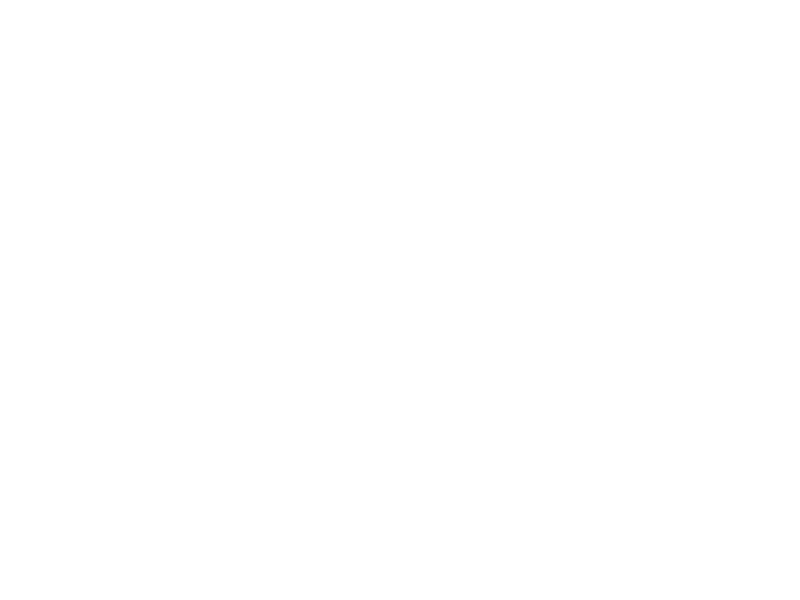

In [19]:
%matplotlib notebook
plt.scatter(X,y)
for w in lst_w:
    y_test = w.data[0].numpy()*X_test + w.data[1].numpy()
    plt.plot(X_test, y_test, alpha=0.005, linewidth=1, color='lightblue')

<IPython.core.display.Javascript object>


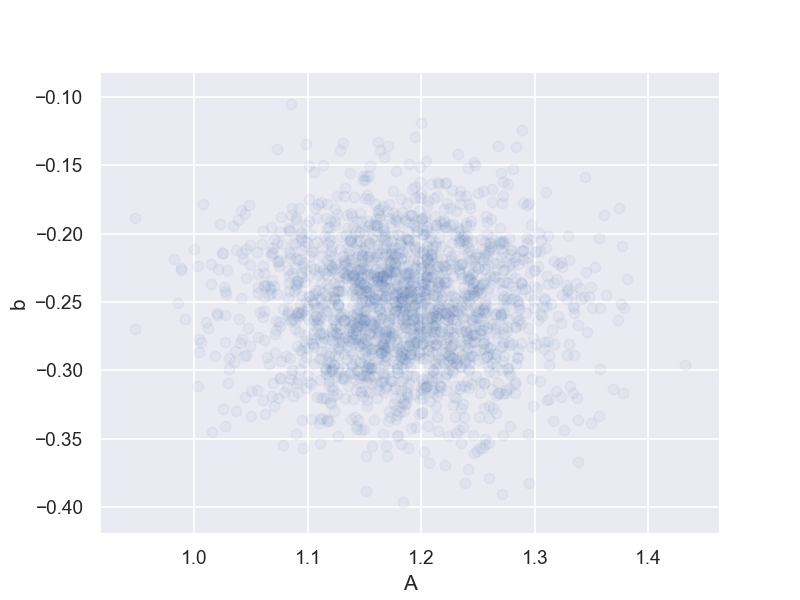

Text(0.5, 0, 'A')

In [20]:
%matplotlib notebook
W = torch.stack(lst_w)
plt.scatter(W[:,0].data, W[:,1].data,alpha=0.05)
plt.ylabel('b')
plt.xlabel('A')